# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import time
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import missingno as msn
import geopandas as gpd
from shapely.geometry import  Point
import seaborn as sns
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold,cross_val_score

# Loading the Dataset

In [20]:
train = pd.read_csv("train.csv", parse_dates=['Dates'])
test = pd.read_csv("test.csv", parse_dates=['Dates'], index_col = 'Id')

# Data Cleaning and Exploring

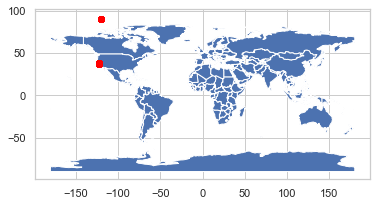

In [26]:
def create_geodf(df):
    geodf = df.copy()
    geodf['Coordinates'] = list(zip(geodf.X, geodf.Y))
    geodf.Coordinates = geodf.Coordinates.apply(Point)
    geodf = gpd.GeoDataFrame(geodf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return geodf

train_geodf = create_geodf(train)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
point = world.plot()
train_geodf.plot(ax=point, color = 'red')
plt.show()

In [27]:
# Identifying the wrong Geo Coordinates
print(train_geodf.loc[train_geodf.Y > 50].count()[0])
train_geodf.loc[train_geodf.Y > 50].sample(10)

67


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Coordinates
719993,2005-02-27 11:00:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Sunday,TARAVAL,NONE,STELMO WY / MONTEREY BL,-120.5,90.0,POINT (-120.50000 90.00000)
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,POINT (-120.50000 90.00000)
772415,2004-05-28 18:15:00,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,BAYVIEW,NONE,I-280 / CESAR CHAVEZ ST,-120.5,90.0,POINT (-120.50000 90.00000)
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0,POINT (-120.50000 90.00000)
677268,2005-10-06 17:30:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Thursday,RICHMOND,NONE,AVENUE OF THE PALMS / EUCLID AV,-120.5,90.0,POINT (-120.50000 90.00000)
685719,2005-08-25 09:26:00,WARRANTS,WARRANT ARREST,Thursday,TENDERLOIN,"ARREST, BOOKED",5THSTNORTH ST / EDDY ST,-120.5,90.0,POINT (-120.50000 90.00000)
677828,2005-10-05 12:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,VANNESS AV / BEACH ST,-120.5,90.0,POINT (-120.50000 90.00000)
688950,2005-08-09 23:15:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,TARAVAL,"ARREST, CITED",GENEVA AV / INTERSTATE280 HY,-120.5,90.0,POINT (-120.50000 90.00000)
871198,2003-02-05 12:00:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,SOUTHERN,NONE,SPEAR ST / THE EMBARCADERO SOUTH ST,-120.5,90.0,POINT (-120.50000 90.00000)
759397,2004-08-03 19:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,LARKIN ST / AUSTIN ST,-120.5,90.0,POINT (-120.50000 90.00000)


In [28]:
# DRopping the Duplicate Values
train.drop_duplicates(inplace=True)
train.replace({'X':-120.5,'Y':90.0},np.NaN,inplace=True)
test.replace({'X':-120.5,'Y':90.0},np.NaN,inplace=True)

imp_mean = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district,['X','Y']] = imp_mean.fit_transform(train.loc[train['PdDistrict'] == district,['X','Y']])
    test.loc[test['PdDistrict'] == district,['X','Y']] = imp_mean.fit_transform(test.loc[test['PdDistrict'] == district,['X','Y']])

train_geodf = create_geodf(train)

# Visualization

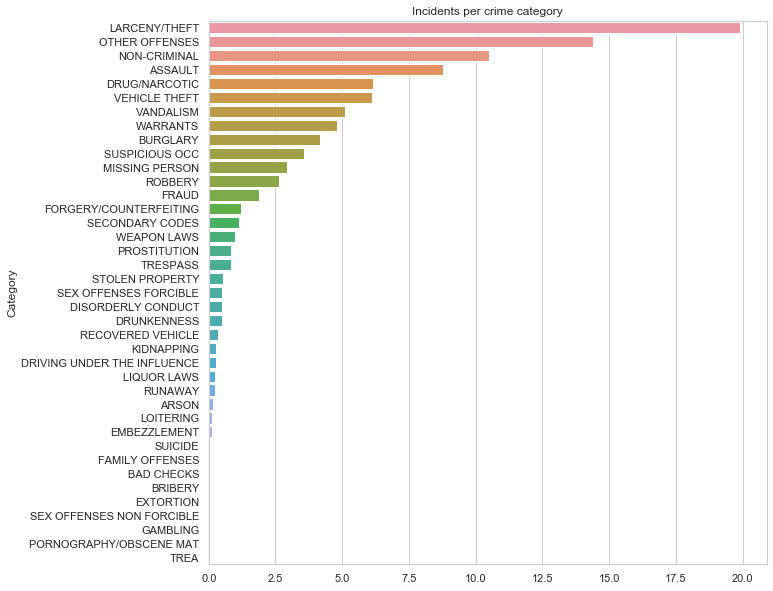

In [29]:
# Visualizing the Top Crime Incidents
data_category = train.groupby('Category').count().iloc[:,0].sort_values(ascending= False)
plt.figure(figsize=(10,10))
sns.set(style= 'whitegrid')
ax = sns.barplot((data_category.values/data_category.values.sum())*100,data_category.index)
plt.title('Incidents per crime category')
plt.show()

In [15]:
#Visualizing Crimes based on Districts
dis_json = r'https://cocl.us/sanfran_geojson'
dist_crime = pd.DataFrame(train['PdDistrict'].value_counts().astype(float))
dist_crime = dist_crime.reset_index()
dist_crime.columns = ['District', 'Number']

map_san = folium.Map(location = [37.77, -122.42], zoom_start= 12)
map_san.choropleth(geo_data = dis_json,data = dist_crime,columns = ['District', 'Number'],
                   key_on='feature.properties.DISTRICT',fill_color='YlOrRd',#YlGn 
                   fill_opacity=0.7,line_opacity=0.2,legend_name='Crime Rate in San Francisco')
folium.LayerControl().add_to(map_san)
map_san.save('#292_folium_chloropleth_SFPD.html')

# Feature Engineering

In [30]:
# Function to create a features on Date Column
def feature_engineering(data):
    data['Date'] = pd.to_datetime(data['Dates'].dt.date)
    data['n_days'] = (data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    data['Day'] = data['Dates'].dt.day
    data['DayOfWeek'] = data['Dates'].dt.weekday
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year
    data['Hour'] = data['Dates'].dt.hour
    data['Minute'] = data['Dates'].dt.minute
    data['Block'] = data['Address'].str.contains('block', case=False)
    
    data.drop(columns=['Dates','Date','Address'], inplace=True)
        
    return data
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)

In [32]:
#Converting Categorical value to numerical
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])
le2 = LabelEncoder()
y = le2.fit_transform(train.pop('Category'))

# Modelling

In [33]:
#Building NaiveBayes Classifier
train_X, val_X, train_y, val_y = train_test_split(train, y)
start_time = time.time()
GNB = GaussianNB()
GNB.fit(train_X, train_y)
predicted = np.array(GNB.predict_proba(val_X))
end_time = time.time()
secs = (end_time - start_time)
loss_function = log_loss(val_y,predicted)
print("Total seconds: {} and loss {}".format(secs, loss_function))

Total seconds: 5.449801445007324 and loss 2.6246770187812416


In [34]:
#Building RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_X, train_y)
predicted_rfc = np.array(rfc.predict_proba(val_X))
end_time = time.time()
secs = (end_time - start_time)
loss_function = log_loss(val_y,predicted_rfc)
print("Total seconds: {} and loss {}".format(secs, loss_function))

Total seconds: 879.2859177589417 and loss 4.838931829473905


In [25]:
#Building KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)
predicted_knn = np.array(knn.predict_proba(val_X))
end_time = time.time()
secs = (end_time - start_time)
loss_function = log_loss(val_y,predicted_knn)
print("Total seconds: {} and loss {}".format(secs, loss_function))

Total seconds: 16.331903219223022 and loss 18.690182488791077


# Evaluation

In [18]:
# Evaluation for Naive Bayes Model
kf = KFold(n_splits=5)
y_pred = GNB.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))
cvs_nb = cross_val_score(GNB,train_X,train_y, scoring='accuracy', cv=kf)
print("Cross_validation_score:",cvs_nb.mean()*100)

Accuracy: 0.19538486836095226
Cross_validation_score: 19.540982290674084


In [ ]:
#Evaluation for Random Forest Classifier
y_pred = rfc.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))
#cvs_rfc = cross_val_score(rfc,train_X,train_y, scoring='accuracy', cv=kf)
#print("Cross_validation_score:",cvs_rfc.mean()*100)

Accuracy: 0.3169248899201579


In [26]:
#Evaluation for K-nearest Neighbors
y_pred = knn.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.17816034202400746
